In [20]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack


Variable initialization

In [21]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [22]:
for i in range(M):
    DCT[:, i] = sp.fftpack.dct(np.eye(M)[:, i], norm='ortho')
    


Generating the 1-D standard basis

In [23]:
C = np.eye(M) # matrix containing the standard basis (a kronecker delta in each column)


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

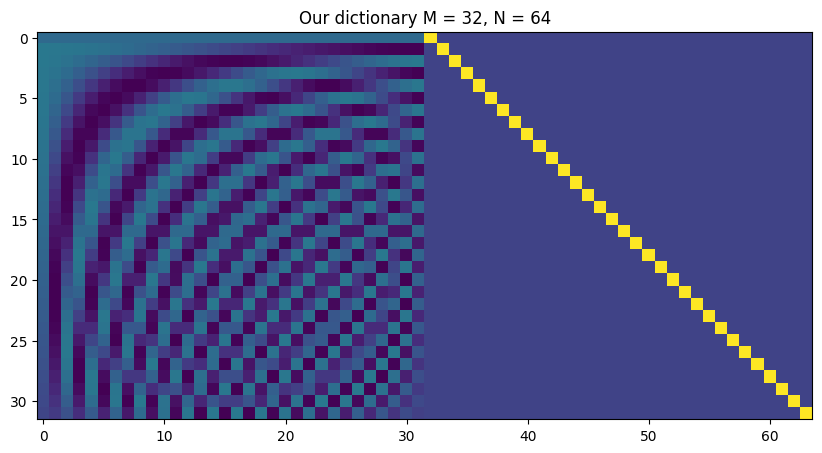

In [24]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [25]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [26]:
x0 = np.zeros(N)
random_vals = np.random.uniform(1.5, 2.5, N) * np.random.choice([-1,1], N)
random_ind = np.random.choice(N, size=L-1, replace=False)
x0[random_ind] = random_vals[random_ind]
print(x0)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -2.44491197  0.
  2.20805597  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -1.8080017   0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


Choose spike location

In [27]:
spikeLocation = np.random.choice(N, size=1, replace=False)
x0[spikeLocation] = x0[spikeLocation] + np.random.uniform(9, 10) * np.random.choice([-1,1])
print(x0)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          9.25934337  0.          0.          0.          0.
  0.          0.          0.          0.         -2.44491197  0.
  2.20805597  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -1.8080017   0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


Synthetize the corresponding signal in the signal domain and add noise


In [28]:
s0 = D @ x0
s = s0 + sigma_noise * np.random.randn(M)

Plot the sparse signal

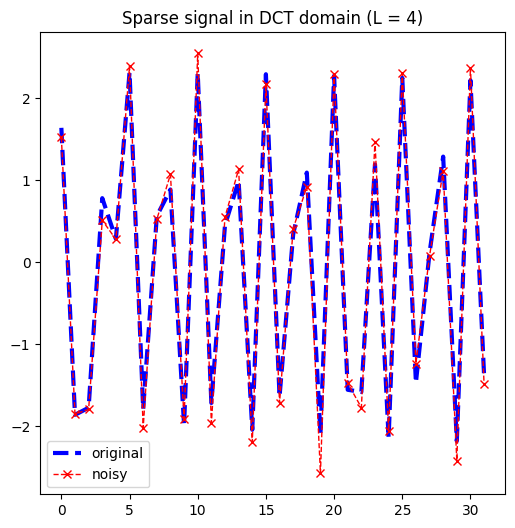

In [29]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [30]:
x_OMP = np.zeros(N)

# residual
r = s

# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [31]:
while np.count_nonzero(x_OMP) < L and np.linalg.norm(r) > MINIMUM_NORM_RES:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        e[j] = np.linalg.norm(r)**2 - ((r.T @ D[:, j])  / np.linalg.norm(D[:, j]))**2

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega = np.append(omega, jStar).astype(int)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x_omega = np.linalg.inv(D[:, omega].T @ D[:, omega]) @ D[:, omega].T @ s 
    print(x_omega.size)
    x_OMP = np.zeros(N)
    x_OMP[omega] = x_omega 

    # update the residual
    r = s - D @ x_OMP


1
2
3
4


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [32]:
s_hat_OMP = D @ x_OMP

Show the result

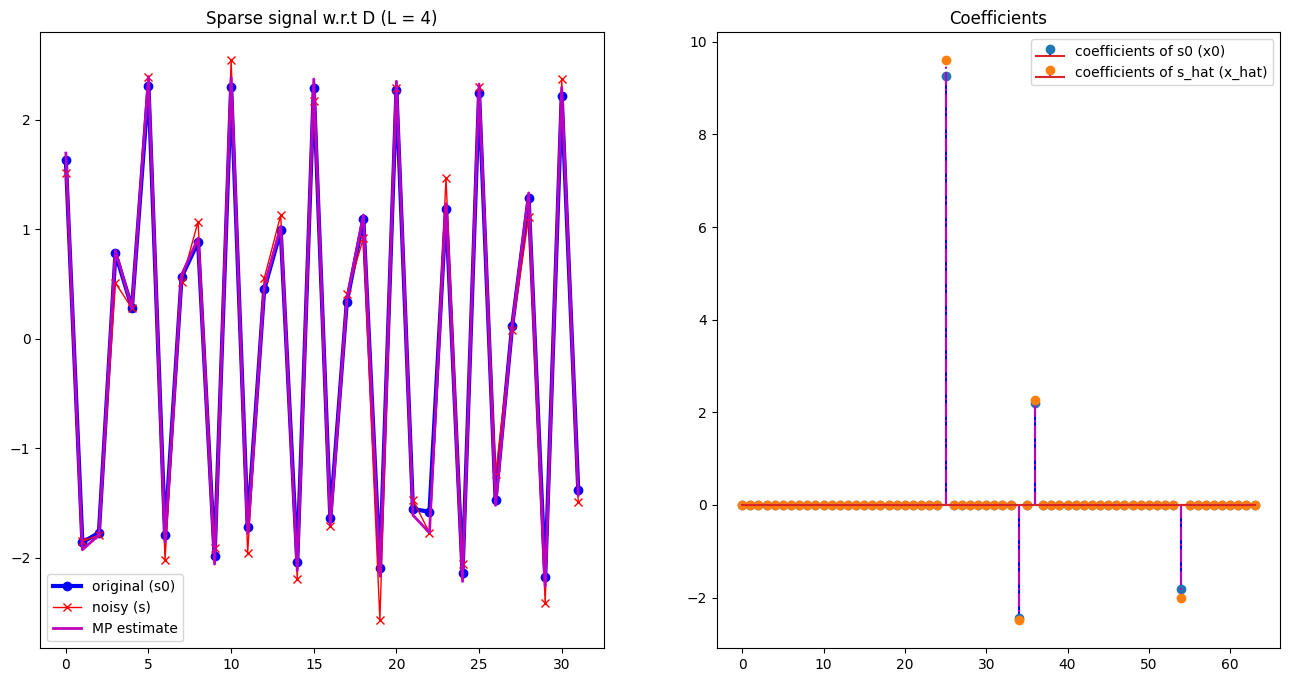

In [33]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [34]:
x_LSOMP = np.zeros(N)

s = s.reshape(-1,1) #I use it to make it as a matrix with just one column for calculation
# residual
r = s
jStar = None
# support set
omega = []
x_omega=None
MINIMUM_NORM_RES = 0.1
cnt = 1

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [35]:
while np.count_nonzero(x_LSOMP) < L and np.linalg.norm(r) > MINIMUM_NORM_RES:

    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
        # at the first iteration perform the usual sweep step
        e = np.zeros(N)
        for j in range(N):
            e[j] = np.linalg.norm(r.reshape(-1))**2 - ((r.reshape(-1).T @ D[:, j])  / np.linalg.norm(D[:, j]))**2
        jStar = np.argmin(e)
        omega = np.append(omega, jStar).astype(int)
        
        D_w = D[:,omega]
        x_omega = np.linalg.inv(D[:, omega].T @ D[:, omega]) @ D[:, omega].T @ s 
        x_LSOMP[omega] = np.linalg.lstsq(D[:,omega], s, rcond=None)[0]
        r = s - D @ x_LSOMP.reshape(-1,1)
        
    else:
        # perform the sweep step by solving the LS problem
        e = np.zeros(N) + np.inf

        for j in range(N):
            if j in omega:
                continue
            d_j = D[:,j].reshape(-1, 1)
            z_w = np.linalg.lstsq(np.block([D_w, d_j]), s, rcond=None)[0]
            s_hat_w = np.block([D_w, d_j])  @ z_w
            e[j] = np.linalg.norm(r - s_hat_w)**2
        jStar = np.argmin(e)

        # UPDATE the support set with the jStar coefficient
        omega = np.append(omega, jStar).astype(int)
        x_omega = np.linalg.lstsq(D[:, omega], s, rcond=None)[0]
        x_LSOMP = np.zeros(N)
        x_LSOMP[omega] = x_omega.reshape(-1)
    
        # update the residual
        r = s - D @ x_LSOMP.reshape(-1,1)
        r = r.reshape(-1,1)



In [36]:
(D @ x_LSOMP).size

32

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [37]:
s_hat_LSOMP = D @ x_LSOMP

Show the result

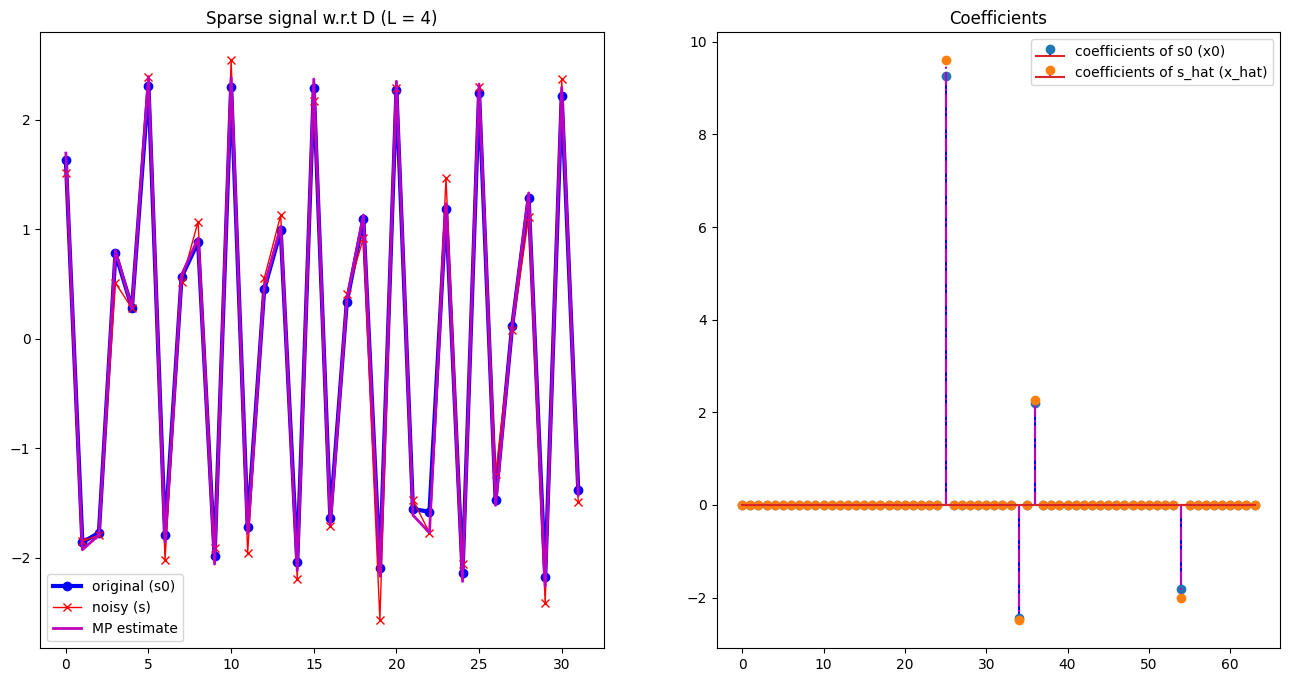

In [38]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])